In [115]:
# !pip install --no-cache-dir gensim
# import gensim
# print(gensim.__version__)
# !pip install faiss-cpu


In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from __future__ import print_function
import argparse
import numpy as np
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from collections import Counter
from collections import defaultdict
from tqdm import tqdm
# from gensim.models import Word2Vec,KeyedVectors
from gensim.models import FastText,KeyedVectors
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import os
import pandas as pd
from itertools import chain
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize


torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Auto-detect GPU


In [117]:

# need validation
N=193
SG_EMBEDD_SIZE=30
SG_WINDOW=5
# Transformer Parameters
N_HEAD = 5         # Number of attention heads
ENCODER_N_LAYERS = 2       # Number of transformer layers
EMBEDDING_SIZE=SG_EMBEDD_SIZE
INTERMIDIATE_DIM=512
BATCH_SIZE=32


In [118]:

def read_data_from_file(filename):
    file_path = os.path.abspath(filename)

    # Read CSV file
    df = pd.read_csv(file_path)

    # Rename columns
    df.columns = ["ID", "Sequence"]
    

    # Drop rows where Sequence is not a string or is missing
    df = df[df["Sequence"].apply(lambda x: isinstance(x, str))].copy()
    df = df[df["Sequence"].apply(lambda x: len(x) > 200 if isinstance(x, str) else False)].copy()


    # Extract fields
    df["Virus_ID"] = df["ID"].apply(lambda x: "".join(x.split("|")[1:]) if "|" in x else "")
    df["Seq_ID"] = df["ID"].apply(lambda x: x.split("|")[0] if "|" in x else "")
    df["Class"] = df["ID"].apply(lambda x: x.split("|")[-1] if "|" in x else "")
    df["Length"] = df["Sequence"].apply(len)

    return df[["Sequence", "Virus_ID", "Seq_ID", "Class", "Length"]]


In [119]:
def ASW(sequence, l_sub):
    """
        sequence (str): The original viral sequence.
        l_sub (int): The length of each subsequence.
        n (int): The number of subsequences to generate.
    """
    l = len(sequence)
    
 
    if N> 1:
        l_stride = (l - l_sub) // (N - 1)
    else:
        l_stride = 1  
    
    subsequences = []

 
    for i in range(0, min(N * l_stride, l - l_sub + 1), l_stride):
        subsequences.append(sequence[i:i + l_sub])
    
    return subsequences


In [120]:
# 0->human  1-> animals
class GatedAttention(nn.Module):
    def __init__(self,N_HEAD,ENCODER_N_LAYERS,EMBEDDING_SIZE,INTERMIDIATE_DIM):
        super(GatedAttention, self).__init__()
        self.M = EMBEDDING_SIZE
        self.L = INTERMIDIATE_DIM
        self.ENCODER_N_LAYERS=ENCODER_N_LAYERS
        self.ATTENTION_BRANCHES = 1
        self.N_HEAD=N_HEAD

        # embedding 
        self.encoder_layer = TransformerEncoderLayer(d_model=self.M, nhead=self.N_HEAD)
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=self.ENCODER_N_LAYERS)
        
        # instance level 
        self.attention_V_1 = nn.Sequential(
            nn.Linear(self.M, self.L), # matrix V
            nn.Tanh()
        )

        self.attention_U_1 = nn.Sequential(
            nn.Linear(self.M, self.L), # matrix U
            nn.Sigmoid()
        )

        self.attention_w_1 = nn.Linear(self.L, self.ATTENTION_BRANCHES) # matrix w (or vector w if self.ATTENTION_BRANCHES==1)


        # bag level 
        self.attention_V_2 = nn.Sequential(
            nn.Linear(self.M, self.L), # matrix V
            nn.Tanh()
        )

        self.attention_U_2 = nn.Sequential(
            nn.Linear(self.M, self.L), # matrix U
            nn.Sigmoid()
        )

        self.attention_w_2 = nn.Linear(self.L, self.ATTENTION_BRANCHES) # matrix w (or vector w if self.ATTENTION_BRANCHES==1)


        
        # classifier
        self.classifier = nn.Sequential(
            nn.Conv1d(in_channels=self.ATTENTION_BRANCHES, out_channels=128, kernel_size=4, padding='same'),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5, padding='same'),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=7, padding='same'),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Flatten(),  # Converts to 1D before fully connected layers
            nn.Linear(128 * ((self.M) // 4), 256),  # Adjust size based on sequence length
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 1),
            nn.Sigmoid() 
        )

    
    def forward(self, datas,ids,Seq_ids):
        #### STEP 1:embeddings
        datas = datas.float()  # Ensure correct dtype
        instances=self.transformer_encoder(datas) 
        
        #### STEP 2: INSTANCE-LEVEL ATTENTION ####
        # Apply attention mechanisms per bag (over instances_per_bag)
        A_V = self.attention_V_1(instances)  
        A_U = self.attention_U_1(instances)  
        A = self.attention_w_1(A_V * A_U)
        A = torch.transpose(A, 1, 0)  
        inner_bags = torch.unique_consecutive(Seq_ids)
      
        output = torch.empty(((len(inner_bags), self.M))).to(device)
        super_ids = torch.empty(((len(inner_bags))))
        for i, bag in enumerate(inner_bags):
            A_vec=F.softmax(A[0][Seq_ids == bag],dim=0)
            output[i] = torch.matmul(A_vec, instances[Seq_ids == bag])
            super_ids[i]=ids[Seq_ids == bag][0]
        
        ### STEP 3: BAG-LEVEL ATTENTION ####
        A_V_2 = self.attention_V_2(output)  
        A_U_2 = self.attention_U_2(output)  
        A_2 = self.attention_w_2(A_V_2 * A_U_2)  
        A_2 = torch.transpose(A_2, 1,0)   

      
        outer_bags = torch.unique_consecutive(super_ids)
        output2 = torch.empty(((len(outer_bags), self.M))).to(device)

        for i, bag in enumerate(outer_bags):
            A_vec_2=F.softmax(A_2[0][super_ids == bag],dim=0)
            output2[i] = torch.matmul(A_vec_2, output[super_ids == bag])

        
        
        ### STEP 4: CLASSIFICATION ####
        # output2 = output2.view(output2.shape[0], -1)  # Flatten over bags_per_bag for classification
        output2 = output2.unsqueeze(1)  # Add a channel dimension


        Y_prob = self.classifier(output2)  # Shape: [batch_size, 1]
        Y_hat = torch.ge(Y_prob, 0.5).float()  # Convert probabilities to binary predictions
        return Y_prob, Y_hat, A

In [121]:
class MILDataset(Dataset):
    def __init__(self, datas, ids, seq_ids, labels):
        self.datas = datas  # Instance features
        self.ids = ids # Virus (outer bag) IDs
        self.seq_ids = seq_ids  # Sequence (inner bag) IDs
        self.labels = labels.to("cpu")  # Labels at the virus (outer bag) level

        # Unique IDs for outer bags (viruses) and their indices
        self.unique_virus_ids, self.virus_indices = torch.unique(self.ids, return_inverse=True)
        
        # Unique IDs for inner bags (sequences) and their indices
        self.unique_seq_ids, self.seq_indices = torch.unique(self.seq_ids, return_inverse=True)

        # Mapping from virus to instance indices  2d array each list is the virus data indecies
        self.virus_bag_indices_list = [torch.where(self.virus_indices == i)[0].to("cpu") for i in tqdm(range(len(self.unique_virus_ids)))]

        # Mapping from sequence to instance indices 2d array each list is the seq data indecies
        self.seq_bag_indices_list = [torch.where(self.seq_indices == i)[0].to("cpu") for i in tqdm( range(len(self.unique_seq_ids)))]

        # Labels assigned at the virus level (each virus gets one label)
        self.virus_labels = [self.labels[indices[0]] for indices in self.virus_bag_indices_list]

        # Precomputed bag-of-bags structure (virus → [seq])
        self.virus_seq_map = {}  # Maps virus_id -> list of sequence indices
        for i, virus_id in tqdm(enumerate(self.unique_virus_ids)):
            self.virus_seq_map[virus_id.item()] = list((self.seq_ids[self.virus_bag_indices_list[i]].tolist()))

        # Precomputed bag IDs for each virus and sequence
        self.precomputed_virus_ids = [torch.full((indices.shape[0],), self.unique_virus_ids[i], dtype=torch.long) 
                                      for i, indices in enumerate(self.virus_bag_indices_list)]

      
        self.datas = self.datas.cpu()


    def __len__(self):
        return len(self.unique_virus_ids)  # Number of unique viruses (outer bags)

    def __getitem__(self, index):
        """ Return outer bag (virus), inner bags (sequences), and instance-level data. """
        
        # Get all instance indices belonging to this virus
        virus_instance_indices = self.virus_bag_indices_list[index]
        # Retrieve instance-level data
        virus_data = self.datas[virus_instance_indices]
        virus_label = self.virus_labels[index]
        virus_id = self.precomputed_virus_ids[index]
        # Find which sequences belong to this virus
       
        seq_ids_in_virus = self.virus_seq_map[virus_id[0].item()]

        return {
            "virus_id": virus_id,
            "virus_data": virus_data,
            "virus_label": virus_label,
            "seq_id": seq_ids_in_virus
        }


def collate_fn(batch):
    """ Custom collate function for Bag-of-Bags MIL """

    batch_size = len(batch)

    all_virus_ids = []
    all_virus_data = []
    all_virus_labels = []
    all_virus_seq_ids = []
   

    for item in batch:
        virus_id = item["virus_id"].tolist()
        virus_data = item["virus_data"].tolist()
        virus_label = item["virus_label"]
        seq_id = item["seq_id"]

        all_virus_seq_ids.extend(seq_id)
        all_virus_ids.extend(virus_id)
        all_virus_data.extend(virus_data)
        all_virus_labels.append(virus_label)
    
    # Convert to tensors
    batch_virus_labels = torch.tensor(all_virus_labels, dtype=torch.float)
    batch_seq_ids = torch.tensor(all_virus_seq_ids, dtype=torch.float)
    batch_virus_datas = torch.tensor(all_virus_data, dtype=torch.float)
    batch_virus_ids = torch.tensor(all_virus_ids, dtype=torch.float)


    return batch_virus_datas, batch_virus_ids,batch_seq_ids, batch_virus_labels


In [122]:
def train(epoch,dataloader):
    model.train()
    running_loss=0.
    acc=0
    total_samples=0
    for batch_data, batch_ids,batch_seq_ids, batch_labels in tqdm(dataloader, desc="Processing Batches"):
        batch_data,batch_ids,batch_seq_ids, batch_labels  = batch_data.to(device), batch_ids.to(device),batch_seq_ids.to(device), batch_labels.to(device)
        Y_prob, Y_hat, A =model(batch_data,batch_ids,batch_seq_ids)
        Y_prob=Y_prob.squeeze(1)
        Y_hat = Y_hat.view_as(batch_labels)
        loss = criterion(Y_prob, batch_labels)
        # Optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        acc += ((Y_hat == batch_labels).sum().item())
        total_samples += batch_labels.size(0)  # Track the total number of samples processed
    print(f'Epoch: {epoch}, Loss: {running_loss:.4f}, LR: {scheduler.get_last_lr()}')
    acc=acc/total_samples*100
    print(f'train accurecy: {acc:.1f}%')
    return running_loss

In [123]:
def plot_confusion_matrix(true_labels, pred_labels, class_names=["Human", "Animal"]):
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


In [124]:
def plot_roc_curve(true_labels, pred_labels):
    # Binarize for ROC
    true_bin = label_binarize(true_labels, classes=[0, 1])
    pred_bin = label_binarize(pred_labels, classes=[0, 1])

    fpr, tpr, _ = roc_curve(true_bin, pred_bin)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


In [170]:
def test(dataloader):
    # print(len(labels))
    model.eval()
    acc=0
    total_samples=0
    output=[]
    true_lables=[]
    with torch.no_grad():
         for batch_data, batch_ids,batch_seq_ids, batch_labels in tqdm(dataloader, desc="Processing Batches"):
            batch_data,batch_ids,batch_seq_ids, batch_labels  = batch_data.to(device), batch_ids.to(device),batch_seq_ids.to(device), batch_labels.to(device)
            Y_prob, Y_hat, A =model(batch_data,batch_ids,batch_seq_ids) 
            output += Y_hat.cpu().tolist()
            true_lables += batch_labels.cpu().tolist()
            Y_prob=Y_prob.squeeze(1)
            Y_hat = Y_hat.view_as(batch_labels)
            acc += ((Y_hat == batch_labels).sum().item())
            total_samples += batch_labels.size(0)  # Track the total number of samples processed

    acc=acc/total_samples*100
    print(f'acc: {acc:.1f}%')
    print("\nClassification Report:")
    print(classification_report(true_lables, output, target_names=["Human", "Animal"]))

    plot_confusion_matrix(true_lables, output)
    plot_roc_curve(true_lables, output)
    
    return output,true_lables

In [160]:
# read dataset
file_name_ncbi_datas="/kaggle/input/ncbi-data-csv/ncbi_cleaned_train_data.csv"
file_name_gasaid_datas="/kaggle/input/ncbi-data-csv/gasaid_cleaned_train_data.csv"
ncbi_test_file_name="/kaggle/input/ncbi-data-csv/ncbi_cleaned_test_data.csv"
gasaid_test_file_name="/kaggle/input/ncbi-data-csv/gasaid_cleaned_test_data.csv"
covid_test="/kaggle/input/ncbi-data-csv/test_covid.csv"

df_covid=read_data_from_file(covid_test)

df_gasaid=read_data_from_file(file_name_gasaid_datas)
df_ncbi=read_data_from_file(file_name_ncbi_datas)
df = pd.concat([df_gasaid, df_ncbi], ignore_index=True)
df_test_ncbi=read_data_from_file(ncbi_test_file_name)
df_test_gasaid=read_data_from_file(gasaid_test_file_name)



In [127]:
def get_lsub_sequence(df):        
    # get the length of the longest seq
    llongest=max(df['Length'])
    lshortest=min(df['Length'])
    print("llongest",llongest)
    llongest=max(df['Length'])
    print("lshortest",lshortest)
    lower_bound = int(llongest / N)
    upper_bound = int(llongest - N + 1)
    l_sub_array=np.arange(lower_bound, upper_bound + 1)
    l_sub=lshortest-N+1
    if l_sub not in l_sub_array:
        print("error ASW")
    return l_sub


l_sub=get_lsub_sequence(df)

llongest 775
lshortest 201


In [128]:
df["Class"] = df["Class"].str.lower()  #Ensure consistent casing

labels = np.array((df["Class"] != "human").astype(int))

ids=df["Virus_ID"]
seq_ids=df["Seq_ID"]+" "+df["Virus_ID"]

# convert string id to numeric
_,ids = np.unique(ids, return_inverse=True)
_,seq_ids = np.unique(seq_ids, return_inverse=True)


In [163]:
#covid tset 
df_covid["Class"] = df_covid["Class"].str.lower()  #Ensure consistent casing
test_covid_labels = np.array((df_covid["Class"] != "human").astype(int))

test_covid_ids=df_covid["Virus_ID"]
test_covid_seq_ids=df_covid["Seq_ID"]+" "+df_covid["Virus_ID"]

# convert test string id to numeric
_,test_covid_ids = np.unique(test_covid_ids, return_inverse=True)
_,test_covid_seq_ids = np.unique(test_covid_seq_ids, return_inverse=True)
test_covid_datas = df_covid['Sequence']
print("length of covid test ",test_covid_datas.shape)


length of covid test  (55,)


In [129]:
#ncbi tset 
df_test_ncbi["Class"] = df_test_ncbi["Class"].str.lower()  #Ensure consistent casing
test_ncbi_labels = np.array((df_test_ncbi["Class"] != "human").astype(int))

test_ncbi_ids=df_test_ncbi["Virus_ID"]
test_ncbi_seq_ids=df_test_ncbi["Seq_ID"]+" "+df_test_ncbi["Virus_ID"]

# convert test string id to numeric
_,test_ncbi_ids = np.unique(test_ncbi_ids, return_inverse=True)
_,test_ncbi_seq_ids = np.unique(test_ncbi_seq_ids, return_inverse=True)
test_ncbi_datas = df_test_ncbi['Sequence']
print("length of ncbi test ",test_ncbi_datas.shape)


length of ncbi test  (1588,)


In [130]:
#gasaid test
df_test_gasaid["Class"] = df_test_gasaid["Class"].str.lower()  #Ensure consistent casing
test_gasaid_labels = np.array((df_test_gasaid["Class"] != "human").astype(int))

test_gasaid_ids=df_test_gasaid["Virus_ID"]
test_gasaid_seq_ids=df_test_gasaid["Seq_ID"]+" "+df_test_gasaid["Virus_ID"]

# convert test string id to numeric
_,test_gasaid_ids = np.unique(test_gasaid_ids, return_inverse=True)
_,test_gasaid_seq_ids = np.unique(test_gasaid_seq_ids, return_inverse=True)
test_gasaid_datas = df_test_gasaid['Sequence']
print("length of gasaid test ",test_gasaid_datas.shape)



length of gasaid test  (5478,)


In [131]:
datas=df["Sequence"]
# Get unique bag IDs
unique_bag_ids = np.unique(ids)

# Split bag IDs into train and test
train_ids, val_ids = train_test_split(unique_bag_ids, test_size=0.2, random_state=42)

# Get indices corresponding to train/test bag IDs
train_indices = np.where(np.isin(ids, train_ids))[0]
val_indices = np.where(np.isin(ids, val_ids))[0]

# # Create train data
train_datas = datas[train_indices]
train_ids = ids[train_indices]
train_seq_ids = seq_ids[train_indices]
train_labels = labels[train_indices]



# # Create val data
val_datas = datas[val_indices]
val_ids = ids[val_indices]
val_seq_ids = seq_ids[val_indices]
val_labels = labels[val_indices]

print("length of train ",train_datas.shape)
print("length of validation ",val_datas.shape)


length of train  (174090,)
length of validation  (43730,)


In [137]:
# Apply ASW 
def create_data_loader(datas,labels,ids,seq_ids,ft_model):
    datas = [ASW(sequence,l_sub) for sequence in datas.tolist()]
    
    labels= np.repeat(labels, N).tolist()
    ids=np.repeat(ids, N).tolist()
    seq_ids=np.repeat(seq_ids, N).tolist()
    
    
    # Apply FastText (CBOW)
    keys_wv=set(list(ft_model.wv.key_to_index.keys()))
    
    embeddings = np.array([
        ft_model.wv[k]  # FastText will handle unknown k-mers
        for kmer in tqdm(datas, desc="FastText inference")
        for k in kmer
    ])
    embeddings=torch.tensor(embeddings).to(device)
    ids=torch.tensor(ids).to(device)
    seq_ids=torch.tensor(seq_ids).to(device)
    labels=torch.tensor(labels).to(device)
    mildataset = MILDataset(embeddings, ids,seq_ids, labels)
    data_loader = DataLoader(mildataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=0, collate_fn=collate_fn)
    return data_loader

In [133]:
# Apply ASW 

train_token_datas = [ASW(sequence,l_sub) for sequence in train_datas.tolist()]

# Train FastText (similar API to Word2Vec)
ft_model = FastText(
    sentences=tqdm(train_token_datas, desc="FastText Training"),
    vector_size=SG_EMBEDD_SIZE,
    window=SG_WINDOW,
    sg=0,  # 1 = skip-gram, 0 = CBOW
    min_count=1,
    workers=5,
    epochs=10
)

train_seq_embeddings = np.array([ft_model.wv[kmer] for kmer in tqdm(train_datas, desc="FastText inference")])


FastText inference: 100%|██████████| 174090/174090 [05:49<00:00, 497.85it/s] 


In [138]:

train_loader = create_data_loader(train_datas, train_labels,train_ids,train_seq_ids,ft_model)
val_loader = create_data_loader(val_datas, val_labels,val_ids,val_seq_ids,ft_model)

100%|██████████| 174090/174090 [06:34<00:00, 441.65it/s]
76266it [00:07, 10177.82it/s]
100%|██████████| 43730/43730 [00:25<00:00, 1711.91it/s]
19067it [00:01, 10778.23it/s]


In [139]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Auto-detect GPU
model = GatedAttention(N_HEAD,ENCODER_N_LAYERS,EMBEDDING_SIZE,INTERMIDIATE_DIM).to(device)  # Move model to GPU
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss().to(device)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)


print(f"Using device: {device}") 
print('Start Training')
for epoch in range(1, 10+1):
    loss = train(epoch, train_loader)
    scheduler.step(loss)  # Update LR based on loss
    if scheduler.num_bad_epochs >= 5:  # Stop after 10 consecutive non-improving epochs
        print(f"Stopping early: No improvement for {scheduler.num_bad_epochs} epochs")
        break

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cuda
Start Training


Processing Batches:   0%|          | 0/2384 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(
Processing Batches: 100%|██████████| 2384/2384 [31:34<00:00,  1.26it/s]


Epoch: 1, Loss: 393.9487, LR: [0.001]
train accurecy: 94.7%


Processing Batches: 100%|██████████| 2384/2384 [31:42<00:00,  1.25it/s]


Epoch: 2, Loss: 315.1952, LR: [0.001]
train accurecy: 96.1%


Processing Batches: 100%|██████████| 2384/2384 [32:01<00:00,  1.24it/s]


Epoch: 3, Loss: 299.0474, LR: [0.001]
train accurecy: 96.4%


Processing Batches: 100%|██████████| 2384/2384 [32:04<00:00,  1.24it/s]


Epoch: 4, Loss: 282.6937, LR: [0.001]
train accurecy: 96.6%


Processing Batches: 100%|██████████| 2384/2384 [32:01<00:00,  1.24it/s]


Epoch: 5, Loss: 273.0027, LR: [0.001]
train accurecy: 96.7%


Processing Batches: 100%|██████████| 2384/2384 [31:34<00:00,  1.26it/s]


Epoch: 6, Loss: 270.4002, LR: [0.001]
train accurecy: 96.8%


Processing Batches: 100%|██████████| 2384/2384 [31:17<00:00,  1.27it/s]


Epoch: 7, Loss: 267.6290, LR: [0.001]
train accurecy: 96.8%


Processing Batches: 100%|██████████| 2384/2384 [31:26<00:00,  1.26it/s]


Epoch: 8, Loss: 257.8744, LR: [0.001]
train accurecy: 96.9%


Processing Batches: 100%|██████████| 2384/2384 [31:15<00:00,  1.27it/s]


Epoch: 9, Loss: 264.5651, LR: [0.001]
train accurecy: 96.9%


Processing Batches: 100%|██████████| 2384/2384 [31:29<00:00,  1.26it/s]

Epoch: 10, Loss: 247.8094, LR: [0.001]
train accurecy: 97.0%


In [140]:
torch.save(model.state_dict(), "model_weights.pth")
ft_model.save("ft_skipgram.model")

In [141]:
# model = GatedAttention(N_HEAD, ENCODER_N_LAYERS, EMBEDDING_SIZE, INTERMIDIATE_DIM).to(device)
# model.load_state_dict(torch.load("model_weights.pth", map_location=device))
# model.eval()
# ft_model = ft_model.load("/kaggle/working/ft_skipgram.model")

100%|██████████| 1588/1588 [00:00<00:00, 12901.13it/s]
902it [00:00, 14744.10it/s]


Start Testing on ncbi test data


Processing Batches: 100%|██████████| 29/29 [00:05<00:00,  5.10it/s]


acc: 98.6%

Classification Report:
              precision    recall  f1-score   support

       Human       0.98      1.00      0.99       642
      Animal       1.00      0.95      0.97       260

    accuracy                           0.99       902
   macro avg       0.99      0.97      0.98       902
weighted avg       0.99      0.99      0.99       902



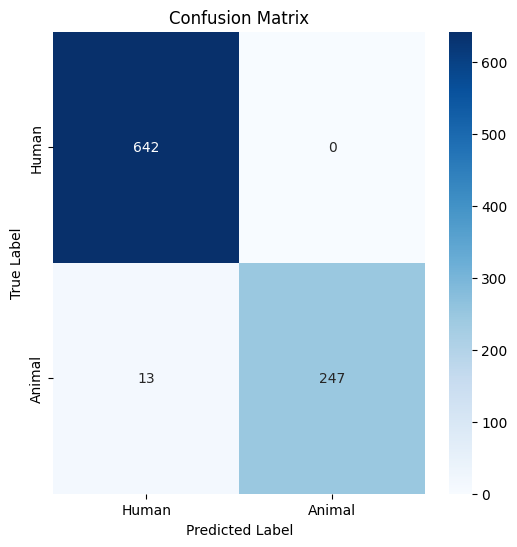

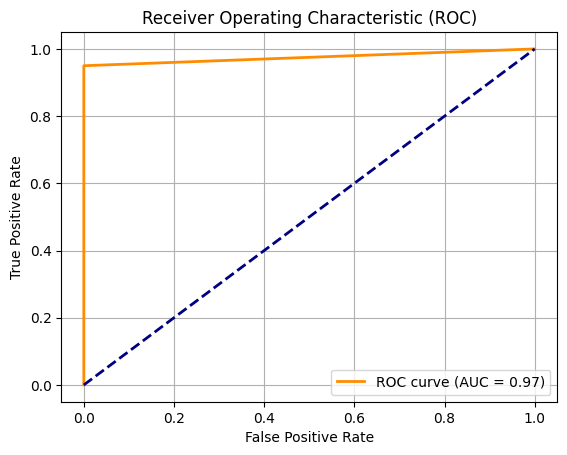

([[0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [1.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [1.0],
  [0.0],
  [0.0],
  [1.0],
  [0.0],
  [1.0],
  [1.0],
  [1.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [1.0],
  [0.0],
  [1.0],
  [1.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [1.0],
  [0.0],
  [1.0],
  [0.0],
  [0.0],
  [1.0],
  [0.0],
  [1.0],
  [0.0],
  [0.0],
  [0.0],
  [1.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [1.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [1.0],
  [0.0],
  [0.0],
  [0.0],
  [1.0],
  [1.0],
  [0.0],
  [1.0],
  [1.0],
  [0.0],
  [1.0],
  [0.0],
  [0.0],
  [1.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [1.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [1.0],
  [0.0],
  [0.0],
  [1.0],
  [1.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [1.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [1.0],
  [1.0],
  [1.0],
 

In [142]:
test_ncbi_loader=create_data_loader(test_ncbi_datas,test_ncbi_labels,test_ncbi_ids,test_ncbi_seq_ids,ft_model)
print('Start Testing on ncbi test data')
test(test_ncbi_loader)


100%|██████████| 5478/5478 [00:00<00:00, 8077.43it/s]
2414it [00:00, 11535.23it/s]


Start Testing on gasaid test data


Processing Batches: 100%|██████████| 76/76 [00:17<00:00,  4.23it/s]


acc: 95.2%

Classification Report:
              precision    recall  f1-score   support

       Human       0.92      0.99      0.96      1273
      Animal       0.99      0.90      0.95      1141

    accuracy                           0.95      2414
   macro avg       0.96      0.95      0.95      2414
weighted avg       0.96      0.95      0.95      2414



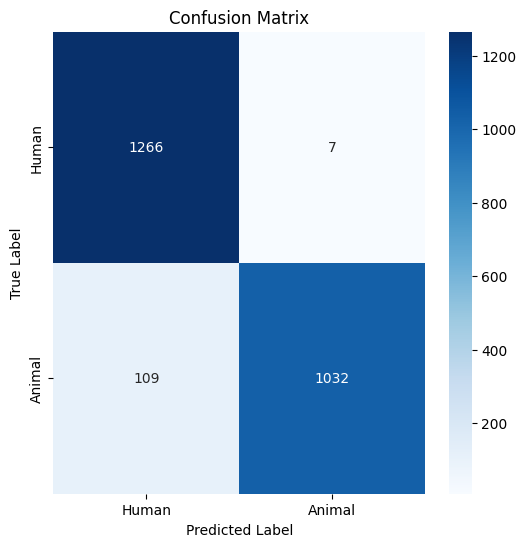

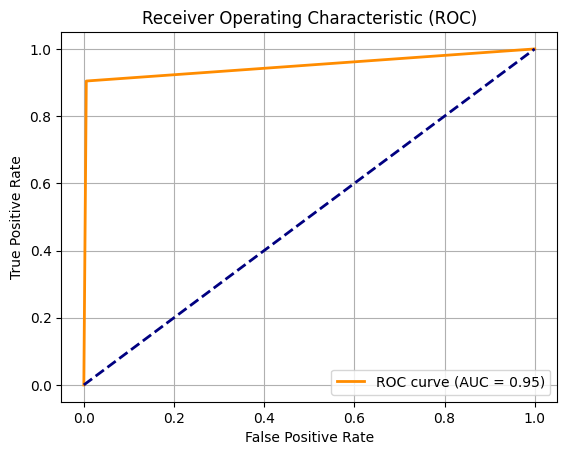

In [143]:
test_gasaid_loader=create_data_loader(test_gasaid_datas,test_gasaid_labels,test_gasaid_ids,test_gasaid_seq_ids,ft_model)
print('Start Testing on gasaid test data')
out2=test(test_gasaid_loader)


100%|██████████| 55/55 [00:00<00:00, 9975.21it/s]
8it [00:00, 5850.82it/s]


Start Testing on gasaid test data


Processing Batches: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

tensor([[0.0150],
        [0.0018],
        [0.0738],
        [0.5115],
        [0.0539],
        [0.0738],
        [0.0177],
        [0.0579]], device='cuda:0')
acc: 87.5%

Classification Report:
              precision    recall  f1-score   support

       Human       1.00      0.88      0.93         8
      Animal       0.00      0.00      0.00         0

    accuracy                           0.88         8
   macro avg       0.50      0.44      0.47         8
weighted avg       1.00      0.88      0.93         8




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


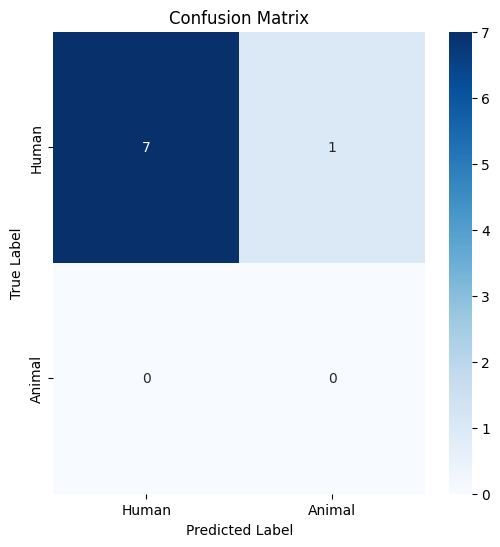

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


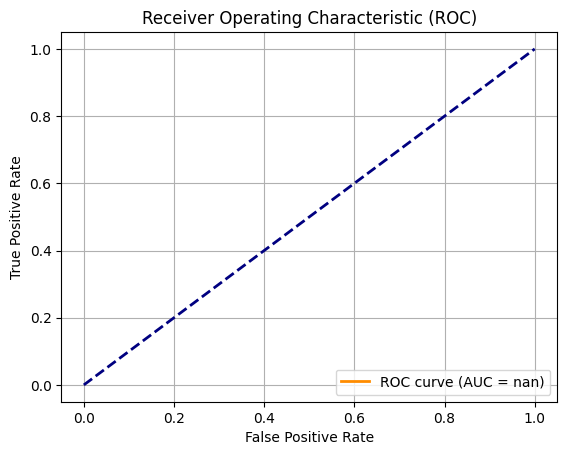

In [169]:
test_covid_loader=create_data_loader(test_covid_datas,test_covid_labels,test_covid_ids,test_covid_seq_ids,ft_model)
print('Start Testing on gasaid test data')
out=test(test_covid_loader)
# print(out)out=
